In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


from scipy.fftpack import fft
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import preprocessing
import seaborn as sns

In [2]:
def load_data(path, type):
    
    if type == "labels":
        
        labels = pd.read_csv(path + "Labels.csv")
        labels = labels.drop('id', axis=1)
        
        return labels
    
    if type == "train" or type == "test":
        
        all_files = sorted(glob.glob(path + "*.csv"))
        
        dataframes = []
        names = []
        
        for file in all_files:
            
            sample_data = pd.read_csv(file, header = None, names = ["X_Axis", "Y_Axis", "Z_Axis"])
        
            dataframes.append(sample_data)
            
            file_name = file[-9 : -4]
            
            names.append(file_name) 
            
        return names, dataframes 

In [3]:
def visualize_dataframe_3d(dataframes, n = 5):
    
    %matplotlib notebook
    
    for i in range(n):
        fig = plt.figure(figsize=(5,3))
        ax = Axes3D(fig)

        xs = dataframes[i]["X_Axis"].values
        ys = dataframes[i]["Y_Axis"].values
        zs = dataframes[i]["Z_Axis"].values

        ax.scatter(xs, ys, zs)
        plt.show()

In [4]:
def visualize_dataframe_axis(dataframes, n = 5):
    
    %matplotlib inline
    
    for i in range(n):
        time = [s for s in range(150)] 

        plt.subplot(3, 1, 1)
        plt.plot(time, list(dataframes[i]["X_Axis"].values), '.-')
        plt.title('A tale of 3 subplots')
        plt.ylabel('X_Axis')

        plt.subplot(3, 1, 2)
        plt.plot(time, list(dataframes[i]["Y_Axis"].values), '.-')
        plt.xlabel('Time (s)')
        plt.ylabel('Y_Axis')

        plt.subplot(3, 1, 3)
        plt.plot(time, list(dataframes[i]["Z_Axis"].values), '.-')
        plt.xlabel('Time (s)')
        plt.ylabel('Z_Axis')

        plt.show()

In [5]:
def interpolate_data(dataframe):
    
    if len(dataframe) < 150:

        for i in range(150 - len(dataframe)):
            dataframe.loc[len(dataframe)] = [np.nan, np.nan, np.nan]

        dataframe["X_Axis"].interpolate(inplace=True)
        dataframe["Y_Axis"].interpolate(inplace=True)
        dataframe["Z_Axis"].interpolate(inplace=True)

    elif len(dataframe) > 150:
        dataframe = dataframe[: 150]
        
    return dataframe

In [6]:
def moving_average(dataframe, step = 10, jump = 1):
    
    average_dataframe = pd.DataFrame(columns = ["X_Axis", "Y_Axis", "Z_Axis"])
    for i in range(0 + step, 150 - step, jump):
        xs = dataframe["X_Axis"][(i - step) : (i + step)].values
        ys = dataframe["Y_Axis"][(i - step) : (i + step)].values
        zs = dataframe["Z_Axis"][(i - step) : (i + step)].values
        
        average_dataframe.loc[len(average_dataframe)] = [xs.mean(), ys.mean(), zs.mean()]
        
    return average_dataframe

In [7]:
def getStatisticsFromComplex(values):
    magnitude = np.absolute(values)
    phase = np.angle(values)
    
    magnitude_mean = magnitude.mean()
    magnitude_std = magnitude.std()
    magnitude_median = np.median(magnitude)
    magnitude_min = magnitude.min()
    magnitude_max = magnitude.max()
    
    phase_mean = phase.mean()
    phase_std = phase.std()
    phase_median = np.median(phase)
    phase_min = phase.min()
    phase_max = phase.max()

    return magnitude_mean, magnitude_std, magnitude_median, magnitude_min, magnitude_max, phase_mean, phase_std, phase_median, phase_min, phase_max

In [8]:
def convert_raw_to_statistics(raw_data):
    column_names = [
                    
                    "X_Mean", "X_Std", "X_Median", "X_Min", "X_Max", "X_Mad", "X_Min_Idx", "X_Max_Idx",
                    "Y_Mean", "Y_Std", "Y_Median", "Y_Min", "Y_Max", "Y_Mad", "Y_Min_Idx", "Y_Max_Idx",
                    "Z_Mean", "Z_Std", "Z_Median", "Z_Min", "Z_Max", "Z_Mad", "Z_Min_Idx", "Z_Max_Idx",
                    "corr_X_Y", "corr_X_Z", "corr_Y_Z",
                   
                    "X_magnitude_mean", "X_magnitude_std", "X_magnitude_median", "X_magnitude_min", "X_magnitude_max", 
                    "X_phase_mean", "X_phase_std", "X_phase_median", "X_phase_min", "X_phase_max", "X_energy",
                    
                    "Y_magnitude_mean", "Y_magnitude_std", "Y_magnitude_median", "Y_magnitude_min", "Y_magnitude_max", 
                    "Y_phase_mean", "Y_phase_std", "Y_phase_median", "Y_phase_min", "Y_phase_max", "Y_energy",
                    
                    "Z_magnitude_mean", "Z_magnitude_std", "Z_magnitude_median", "Z_magnitude_min", "Z_magnitude_max", 
                    "Z_phase_mean", "Z_phase_std", "Z_phase_median", "Z_phase_min", "Z_phase_max", "Z_energy"
                    
                   ]
    
    #print(len(column_names))
    statistical_data = pd.DataFrame(columns = column_names)
    
    for data in raw_data:
        x_mean = data["X_Axis"].mean()
        x_std = data["X_Axis"].std()
        x_median = data["X_Axis"].median()
        x_min = data["X_Axis"].min()
        x_max = data["X_Axis"].max()
        x_mad = data["X_Axis"].mad(skipna = True)
        x_min_idx = data["X_Axis"].idxmin()
        x_max_idx = data["X_Axis"].idxmax()
        
        x_fft = fft(data["X_Axis"].values)
        
        x_magnitude_mean, x_magnitude_std, x_magnitude_median, x_magnitude_min, x_magnitude_max, x_phase_mean, x_phase_std, x_phase_median, x_phase_min, x_phase_max, = getStatisticsFromComplex(x_fft)
        
        x_energy = np.sum(np.abs(x_fft) ** 2) / 150


        y_mean = data["Y_Axis"].mean()
        y_std = data["Y_Axis"].std()
        y_median = data["Y_Axis"].median()
        y_min = data["Y_Axis"].min()
        y_max = data["Y_Axis"].max()
        y_mad = data["Y_Axis"].mad(skipna = True)
        y_min_idx = data["Y_Axis"].idxmin()
        y_max_idx = data["Y_Axis"].idxmax()


        y_fft = fft(data["Y_Axis"].values)
        
        y_magnitude_mean, y_magnitude_std, y_magnitude_median, y_magnitude_min, y_magnitude_max, y_phase_mean, y_phase_std, y_phase_median, y_phase_min, y_phase_max, = getStatisticsFromComplex(y_fft)
        
        y_energy = np.sum(np.abs(y_fft) ** 2) / 150
        
        z_mean = data["Z_Axis"].mean()
        z_std = data["Z_Axis"].std()
        z_median = data["Z_Axis"].median()
        z_min = data["Z_Axis"].min()
        z_max = data["Z_Axis"].max()
        z_mad = data["Z_Axis"].mad(skipna = True)
        z_min_idx = data["Z_Axis"].idxmin()
        z_max_idx = data["Z_Axis"].idxmax()

        
        z_fft = fft(data["Z_Axis"].values)
        
        z_magnitude_mean, z_magnitude_std, z_magnitude_median, z_magnitude_min, z_magnitude_max, z_phase_mean, z_phase_std, z_phase_median, z_phase_min, z_phase_max = getStatisticsFromComplex(z_fft)

        z_energy = np.sum(np.abs(z_fft) ** 2) / 150
        
        
        corr_X_Y = np.corrcoef(data["X_Axis"].values, data["Y_Axis"].values)
        corr_X_Z = np.corrcoef(data["X_Axis"].values, data["Z_Axis"].values)
        corr_Y_Z = np.corrcoef(data["Y_Axis"].values, data["Z_Axis"].values)
        
        
        sample = [
                    x_mean, x_std, x_median, x_min, x_max, x_mad, x_min_idx, x_max_idx, y_mean, y_std, y_median, y_min, y_max, y_mad, y_min_idx, y_max_idx, z_mean, z_std, z_median, z_min, z_max, z_mad, z_min_idx, z_max_idx, corr_X_Y[0,1], corr_X_Z[0,1], corr_Y_Z[0,1],
                    
                    x_magnitude_mean, x_magnitude_std, x_magnitude_median, x_magnitude_min, x_magnitude_max, x_phase_mean, x_phase_std, x_phase_median, x_phase_min, x_phase_max, x_energy,
            
                    y_magnitude_mean, y_magnitude_std, y_magnitude_median, y_magnitude_min, y_magnitude_max, y_phase_mean, y_phase_std, y_phase_median, y_phase_min, y_phase_max, y_energy,
                    
                    z_magnitude_mean, z_magnitude_std, z_magnitude_median, z_magnitude_min, z_magnitude_max, z_phase_mean, z_phase_std, z_phase_median, z_phase_min, z_phase_max, z_energy
                 
                 ]
        
        statistical_data.loc[len(statistical_data)] = sample

            
    return statistical_data

In [9]:
def svc_param_selection(X, y):
    print("START")
    Cs = [1, 0.5, 0.1, 0.01]
    degrees = [1, 2, 3, 4]
    kernels = ['poly']
    
    param_grid = {'C': Cs, 'kernel': kernels, 'degree': degrees}
    algorithm = SVC(gamma = 1)
    
    
    folds = KFold(n_splits = 5, random_state = 42)
    clf = GridSearchCV(algorithm, param_grid, cv = folds, scoring = "accuracy")
    cross_score = cross_val_score(estimator = algorithm, X = X, y = y, cv = folds)
    meanScore = np.average(cross_score)
    print("Training Score: ", meanScore)
    
    clf.fit(X, y)
    print('Best score: {}'.format(clf.best_score_))
    print('Best parameters: {}'.format(clf.best_params_))
    print("STOP")
    return clf.best_params_

In [26]:
test_path = "/home/adrian/Desktop/Python/Personal/Competitie/Dataset/TestData/"

train_path = "/home/adrian/Desktop/Python/Personal/Competitie/Dataset/TrainData/"

labels_path = "/home/adrian/Desktop/Python/Personal/Competitie/Dataset/"

labels = load_data(labels_path, type = "labels")

train_names, raw_train_dataframes = load_data(train_path, type = "train")

test_names, raw_test_dataframes = load_data(test_path, type = "test")

In [27]:
print("Verificare Citire")

#display(labels.head(n = 20))

display(raw_train_dataframes[0].head(n = 10))

# print(train_names[:10])

# display(test_dataframes[10].head(n = 20))

# print(test_names[:10])

Verificare Citire


,X_Axis,Y_Axis,Z_Axis
0,-0.767342,4.330513,7.996035
1,-0.826000,4.371214,7.986458
2,-0.819415,4.401740,8.008605
3,-0.809240,4.446631,8.027160
4,-0.798466,4.450222,8.033744
5,-0.762553,4.480150,8.039729
6,-0.725443,4.459201,8.024766
7,-0.667384,4.477157,8.056489
8,-0.653617,4.520253,8.105570
9,-0.694318,4.498705,8.123527


<IPython.core.display.Javascript object>


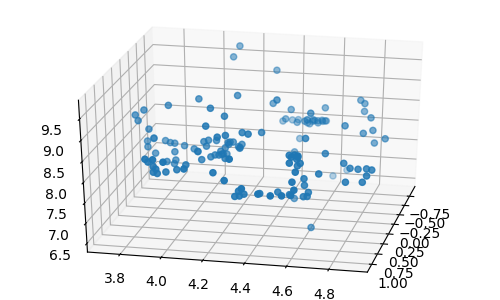

In [144]:
visualize_dataframe_3d(raw_train_dataframes, 1)

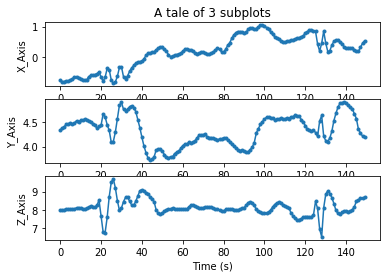

In [29]:
visualize_dataframe_axis(raw_train_dataframes, 1)

In [30]:
interpolated_dataframes = []
for i in range(len(raw_train_dataframes)):
    interpolated_dataframes.append(interpolate_data(raw_train_dataframes[i]))

In [32]:
dataframes = []

for i in range(len(interpolated_dataframes)):
    average_dataframe = moving_average(interpolated_dataframes[i], 10)
    dataframes.append(average_dataframe)

In [33]:
display(dataframes[0].head(n = 10))

,X_Axis,Y_Axis,Z_Axis
0,-0.704793,4.463211,8.106468
1,-0.699945,4.468089,8.089948
2,-0.699137,4.482215,8.030601
3,-0.691954,4.492061,7.967873
4,-0.670676,4.491642,7.945787
5,-0.652180,4.485357,7.980114
6,-0.652510,4.465515,8.053915
7,-0.660321,4.447529,8.137652
8,-0.668521,4.438191,8.194694
9,-0.668222,4.439957,8.214237


<IPython.core.display.Javascript object>


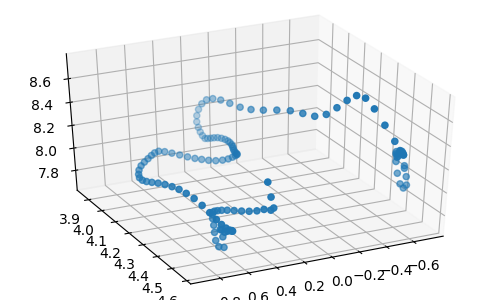

In [145]:
visualize_dataframe_3d(dataframes, 1)

In [103]:
statistical_data = convert_raw_to_statistics(interpolated_dataframes)
display(statistical_data.head(n = 10))

,X_Mean,X_Std,X_Median,X_Min,X_Max,X_Mad,X_Min_Idx,X_Max_Idx,Y_Mean,Y_Std,...,Z_magnitude_std,Z_magnitude_median,Z_magnitude_min,Z_magnitude_max,Z_phase_mean,Z_phase_std,Z_phase_median,Z_phase_min,Z_phase_max,Z_energy
0,0.159011,0.546217,0.219968,-0.881665,1.044471,0.436526,26.0,98.0,4.324080,0.302839,...,99.049813,2.223194,0.145085,1220.013964,2.094395e-02,2.034923,0.005687,-3.106083,3.141593,9952.255436
1,0.177287,0.617926,0.268450,-1.105523,1.126472,0.539088,0.0,104.0,4.521625,0.603011,...,106.395423,1.196751,0.152531,1309.577449,2.094395e-02,1.663468,0.017682,-3.124425,3.141593,11455.539485
2,-1.616960,0.853973,-2.008436,-2.646790,0.034716,0.744438,100.0,19.0,3.657478,0.281871,...,97.992427,0.629389,0.069493,1205.452416,4.736952e-17,1.376368,0.000000,-3.137305,3.137305,9713.747619
3,-0.454427,0.626479,-0.574609,-1.720832,0.661398,0.543167,131.0,18.0,3.466273,0.472386,...,103.366683,2.278742,0.077977,1272.877327,2.094395e-02,1.679332,0.018198,-3.120831,3.141593,10865.034864
4,-0.374194,0.837185,-0.043993,-2.050035,0.816423,0.774655,124.0,35.0,3.670016,0.383599,...,102.876477,5.879033,0.697918,1268.432498,2.094395e-02,1.714817,0.041516,-3.099910,3.141593,10880.436852
5,0.040558,0.539488,0.013168,-0.890045,1.116297,0.480193,0.0,29.0,4.212514,0.605243,...,108.106942,1.194558,0.084265,1329.022567,2.094395e-02,1.861120,0.006584,-3.109431,3.141593,11863.265081
6,0.944257,0.218897,0.966359,0.499790,1.443105,0.176150,149.0,54.0,4.725500,0.117619,...,107.357638,2.289665,0.376222,1322.059031,4.736952e-17,1.674784,0.000000,-3.100111,3.100111,11681.787441
7,-0.656295,0.283433,-0.665887,-1.259949,0.022146,0.227984,108.0,148.0,6.343026,0.293640,...,76.455280,0.603103,0.100757,940.322710,5.921189e-18,1.739014,0.000000,-3.069077,3.069077,5923.653097
8,-0.917610,0.324510,-0.966060,-1.575385,-0.205901,0.272051,96.0,129.0,4.284971,0.631196,...,98.416954,1.502670,0.086281,1210.774734,0.000000e+00,1.495982,0.000000,-3.031029,3.031029,9827.586358
9,-1.119864,0.279094,-1.181239,-1.490989,-0.388459,0.209187,147.0,110.0,6.231892,0.294263,...,77.089388,0.714601,0.020515,948.418708,2.094395e-02,2.253662,0.008157,-3.068371,3.141593,6016.740664


In [104]:
statistical_data.corr()

,X_Mean,X_Std,X_Median,X_Min,X_Max,X_Mad,X_Min_Idx,X_Max_Idx,Y_Mean,Y_Std,...,Z_magnitude_std,Z_magnitude_median,Z_magnitude_min,Z_magnitude_max,Z_phase_mean,Z_phase_std,Z_phase_median,Z_phase_min,Z_phase_max,Z_energy
X_Mean,1.000000,-0.083217,0.979062,0.755986,0.758927,-0.085792,0.008303,0.005981,-0.029286,-0.009610,...,0.248438,0.104056,0.029219,0.249396,0.020354,0.022018,-0.002330,-0.019404,0.028304,0.252865
X_Std,-0.083217,1.000000,-0.075494,-0.599595,0.468579,0.990437,0.013540,-0.019547,0.038030,0.444697,...,-0.091752,0.049493,0.039569,-0.094953,-0.003192,0.000704,0.044158,0.037248,-0.045739,-0.095518
X_Median,0.979062,-0.075494,1.000000,0.708021,0.713047,-0.078049,0.019946,0.000874,-0.027049,-0.013262,...,0.239434,0.102758,0.028539,0.240327,0.022840,0.022349,-0.000336,-0.023623,0.033220,0.243834
X_Min,0.755986,-0.599595,0.708021,1.000000,0.301464,-0.570651,-0.018740,0.020267,-0.053808,-0.299050,...,0.221326,-0.038183,-0.044457,0.224081,0.021996,0.019697,-0.018255,-0.033037,0.044176,0.223504
X_Max,0.758927,0.468579,0.713047,0.301464,1.000000,0.437828,0.004315,-0.005174,-0.004120,0.301036,...,0.173911,0.160817,0.061384,0.172762,0.010594,0.019198,0.021097,0.008538,-0.006901,0.177022
X_Mad,-0.085792,0.990437,-0.078049,-0.570651,0.437828,1.000000,0.007688,-0.020079,0.034772,0.416959,...,-0.095304,0.031509,0.030873,-0.098318,0.000578,0.003912,0.045138,0.033170,-0.040723,-0.099612
X_Min_Idx,0.008303,0.013540,0.019946,-0.018740,0.004315,0.007688,1.000000,-0.446283,0.032379,-0.035896,...,-0.019262,0.029103,0.036466,-0.019024,-0.058560,-0.127821,-0.045836,0.057943,-0.061443,-0.019326
X_Max_Idx,0.005981,-0.019547,0.000874,0.020267,-0.005174,-0.020079,-0.446283,1.000000,-0.012721,0.020176,...,0.003652,-0.023530,-0.032442,0.003394,0.015402,0.084165,0.013439,-0.047900,0.043547,0.003448
Y_Mean,-0.029286,0.038030,-0.027049,-0.053808,-0.004120,0.034772,0.032379,-0.012721,1.000000,-0.046595,...,-0.794249,-0.135825,-0.051282,-0.795281,-0.016168,-0.053734,-0.001557,0.066284,-0.067272,-0.783700
Y_Std,-0.009610,0.444697,-0.013262,-0.299050,0.301036,0.416959,-0.035896,0.020176,-0.046595,1.000000,...,0.072797,0.159751,0.115482,0.066141,-0.004227,0.006591,0.060519,0.046607,-0.059369,0.078927


In [110]:
# to_remove = ['X_Min_Idx', 'Y_Min_Idx', 'Z_Min_Idx', 'X_Max_Idx', 'Y_Max_Idx', 'Z_Max_Idx', 'X_Std', 'Y_Std', 'Z_Std']
# statistical_data.drop(to_remove, inplace = True, axis = 1)
# display(statistical_data.head(n = 10))

,X_Mean,X_Median,X_Min,X_Max,X_Mad,Y_Mean,Y_Median,Y_Min,Y_Max,Y_Mad,Z_Mean,Z_Median,Z_Min,Z_Max,Z_Mad,corr_X_Y,corr_X_Z,corr_Y_Z
0,0.159011,0.219968,-0.881665,1.044471,0.436526,4.324080,4.340987,3.726575,4.896142,0.258853,8.133426,8.072051,6.514024,9.699510,0.301191,-0.184767,-0.219530,-0.254181
1,0.177287,0.268450,-1.105523,1.126472,0.539088,4.521625,4.579210,2.644994,5.616797,0.469549,8.730516,8.698434,7.632715,9.897031,0.299154,0.073862,0.041400,-0.065739
2,-1.616960,-2.008436,-2.646790,0.034716,0.744438,3.657478,3.575441,3.266290,4.272453,0.233438,8.036349,8.016685,7.251439,9.764751,0.287437,-0.439834,0.628561,-0.334879
3,-0.454427,-0.574609,-1.720832,0.661398,0.543167,3.466273,3.438373,2.552219,4.365827,0.391469,8.485849,8.560768,5.910087,10.348338,0.446755,0.121087,0.030433,-0.437792
4,-0.374194,-0.043993,-2.050035,0.816423,0.774655,3.670016,3.677494,3.029862,4.583101,0.313421,8.456217,8.526350,4.358046,11.045650,0.619995,0.188831,0.010355,-0.415893
5,0.040558,0.013168,-0.890045,1.116297,0.480193,4.212514,4.306271,2.818574,5.887940,0.468856,8.860150,8.844480,7.452551,10.651205,0.625746,-0.043828,0.066665,-0.358087
6,0.944257,0.966359,0.499790,1.443105,0.176150,4.725500,4.743213,4.478355,5.042788,0.095854,8.813727,8.869320,7.595605,9.878476,0.334506,-0.068306,-0.059528,-0.552258
7,-0.656295,-0.665887,-1.259949,0.022146,0.227984,6.343026,6.253356,5.867590,6.914454,0.252654,6.268818,6.281487,5.195418,7.308300,0.340658,-0.551177,0.571748,-0.596872
8,-0.917610,-0.966060,-1.575385,-0.205901,0.272051,4.284971,4.286219,2.985569,5.349245,0.545299,8.071832,8.058284,6.311116,9.784504,0.483122,-0.482175,0.571598,-0.708783
9,-1.119864,-1.181239,-1.490989,-0.388459,0.209187,6.231892,6.259042,5.630564,7.082048,0.232095,6.322791,6.307225,5.575497,7.295731,0.297268,-0.297838,0.106885,-0.441753


In [82]:
# Create correlation matrix
corr_matrix = statistical_data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
statistical_data.drop(to_drop, inplace = True, axis=1)

display(statistical_data.head(n = 10))

,X_Mean,X_Std,X_Min,X_Max,X_Min_Idx,X_Max_Idx,Y_Mean,Y_Std,Y_Min,Y_Max,...,Y_phase_min,Y_phase_max,Z_magnitude_mean,Z_magnitude_median,Z_magnitude_min,Z_phase_mean,Z_phase_std,Z_phase_median,Z_phase_min,Z_phase_max
0,0.159011,0.546217,-0.881665,1.044471,26.0,98.0,4.324080,0.302839,3.726575,4.896142,...,-3.081593,3.141593,11.890752,2.223194,0.145085,2.094395e-02,2.034923,0.005687,-3.106083,3.141593
1,0.177287,0.617926,-1.105523,1.126472,0.0,104.0,4.521625,0.603011,2.644994,5.616797,...,-3.089499,3.089499,11.642742,1.196751,0.152531,2.094395e-02,1.663468,0.017682,-3.124425,3.141593
2,-1.616960,0.853973,-2.646790,0.034716,100.0,19.0,3.657478,0.281871,3.266290,4.272453,...,-3.139144,3.141593,10.546652,0.629389,0.069493,4.736952e-17,1.376368,0.000000,-3.137305,3.137305
3,-0.454427,0.626479,-1.720832,0.661398,131.0,18.0,3.466273,0.472386,2.552219,4.365827,...,-3.101041,3.141593,13.429957,2.278742,0.077977,2.094395e-02,1.679332,0.018198,-3.120831,3.141593
4,-0.374194,0.837185,-2.050035,0.816423,124.0,35.0,3.670016,0.383599,3.029862,4.583101,...,-3.137383,3.141593,17.229837,5.879033,0.697918,2.094395e-02,1.714817,0.041516,-3.099910,3.141593
5,0.040558,0.539488,-0.890045,1.116297,0.0,29.0,4.212514,0.605243,2.818574,5.887940,...,-3.127849,3.141593,13.272309,1.194558,0.084265,2.094395e-02,1.861120,0.006584,-3.109431,3.141593
6,0.944257,0.218897,0.499790,1.443105,149.0,54.0,4.725500,0.117619,4.478355,5.042788,...,-3.047565,3.141593,12.495001,2.289665,0.376222,4.736952e-17,1.674784,0.000000,-3.100111,3.100111
7,-0.656295,0.283433,-1.259949,0.022146,108.0,148.0,6.343026,0.293640,5.867590,6.914454,...,-3.026359,3.141593,8.845521,0.603103,0.100757,5.921189e-18,1.739014,0.000000,-3.069077,3.069077
8,-0.917610,0.324510,-1.575385,-0.205901,96.0,129.0,4.284971,0.631196,2.985569,5.349245,...,-3.126275,3.141593,11.903343,1.502670,0.086281,0.000000e+00,1.495982,0.000000,-3.031029,3.031029
9,-1.119864,0.279094,-1.490989,-0.388459,147.0,110.0,6.231892,0.294263,5.630564,7.082048,...,-3.130225,3.130225,8.600404,0.714601,0.020515,2.094395e-02,2.253662,0.008157,-3.068371,3.141593


In [111]:
# Use Raw Data for Classifier

# data = np.zeros([9000, 150, 3])
# for i in range(len(interpolated_dataframes)):
#     data[i][:] = interpolated_dataframes[i].values[0 : 150]
    
# print(data.shape)
# print(data[0][0])

# X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8, test_size = 0.2)
# print ("Training set has {} samples.".format(X_train.shape[0]))
# print ("Testing set has {} samples.".format(X_test.shape[0]))

# nsamples, nx, ny = X_train.shape
# X_train = X_train.reshape((nsamples, nx * ny))
# print(X_train)

# nsamples, nx, ny = X_test.shape
# X_test = X_test.reshape((nsamples, nx * ny))

In [127]:
display(statistical_data.head(n = 10))

,X_Mean,X_Std,X_Median,X_Min,X_Max,X_Mad,X_Min_Idx,X_Max_Idx,Y_Mean,Y_Std,...,Z_magnitude_std,Z_magnitude_median,Z_magnitude_min,Z_magnitude_max,Z_phase_mean,Z_phase_std,Z_phase_median,Z_phase_min,Z_phase_max,Z_energy
0,0.159011,0.546217,0.219968,-0.881665,1.044471,0.436526,26.0,98.0,4.324080,0.302839,...,99.049813,2.223194,0.145085,1220.013964,2.094395e-02,2.034923,0.005687,-3.106083,3.141593,9952.255436
1,0.177287,0.617926,0.268450,-1.105523,1.126472,0.539088,0.0,104.0,4.521625,0.603011,...,106.395423,1.196751,0.152531,1309.577449,2.094395e-02,1.663468,0.017682,-3.124425,3.141593,11455.539485
2,-1.616960,0.853973,-2.008436,-2.646790,0.034716,0.744438,100.0,19.0,3.657478,0.281871,...,97.992427,0.629389,0.069493,1205.452416,4.736952e-17,1.376368,0.000000,-3.137305,3.137305,9713.747619
3,-0.454427,0.626479,-0.574609,-1.720832,0.661398,0.543167,131.0,18.0,3.466273,0.472386,...,103.366683,2.278742,0.077977,1272.877327,2.094395e-02,1.679332,0.018198,-3.120831,3.141593,10865.034864
4,-0.374194,0.837185,-0.043993,-2.050035,0.816423,0.774655,124.0,35.0,3.670016,0.383599,...,102.876477,5.879033,0.697918,1268.432498,2.094395e-02,1.714817,0.041516,-3.099910,3.141593,10880.436852
5,0.040558,0.539488,0.013168,-0.890045,1.116297,0.480193,0.0,29.0,4.212514,0.605243,...,108.106942,1.194558,0.084265,1329.022567,2.094395e-02,1.861120,0.006584,-3.109431,3.141593,11863.265081
6,0.944257,0.218897,0.966359,0.499790,1.443105,0.176150,149.0,54.0,4.725500,0.117619,...,107.357638,2.289665,0.376222,1322.059031,4.736952e-17,1.674784,0.000000,-3.100111,3.100111,11681.787441
7,-0.656295,0.283433,-0.665887,-1.259949,0.022146,0.227984,108.0,148.0,6.343026,0.293640,...,76.455280,0.603103,0.100757,940.322710,5.921189e-18,1.739014,0.000000,-3.069077,3.069077,5923.653097
8,-0.917610,0.324510,-0.966060,-1.575385,-0.205901,0.272051,96.0,129.0,4.284971,0.631196,...,98.416954,1.502670,0.086281,1210.774734,0.000000e+00,1.495982,0.000000,-3.031029,3.031029,9827.586358
9,-1.119864,0.279094,-1.181239,-1.490989,-0.388459,0.209187,147.0,110.0,6.231892,0.294263,...,77.089388,0.714601,0.020515,948.418708,2.094395e-02,2.253662,0.008157,-3.068371,3.141593,6016.740664


In [111]:
X_train, X_test, y_train, y_test = train_test_split(statistical_data, labels['class'].values, train_size = 0.8, test_size = 0.2)
print ("Training set has {} samples.".format(X_train.shape[0]))
print ("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 7200 samples.
Testing set has 1800 samples.


In [112]:
scaler = preprocessing.StandardScaler() 

scaler.fit(X_train)

scaled_x_train = scaler.transform(X_train)

scaled_x_test = scaler.transform(X_test)

In [113]:
dictionary = svc_param_selection(scaled_x_train, y_train) 
C = dictionary['C']
kernel = dictionary['kernel']
degree = dictionary['degree']
# C = C, kernel = kernel, degree = degree

classifier = SVC(C = C, kernel = kernel, degree = degree, gamma = 1)
classifier.fit(scaled_x_train, y_train)
y_predict = classifier.predict(scaled_x_test)

accuracy = accuracy_score(y_test, y_predict)
print ("Support Vector Machine Accuracy:", accuracy)

START
Training Score:  0.06625
Best score: 0.9386111111111111
Best parameters: {'C': 0.5, 'degree': 1, 'kernel': 'poly'}
STOP
Support Vector Machine Accuracy: 0.9366666666666666


In [114]:
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(classifier, random_state=1).fit(scaled_x_test, y_test)
eli5.show_weights(perm, feature_names = statistical_data.columns.tolist())

Weight,Feature
0.0763 ± 0.0139,corr_Y_Z
0.0701 ± 0.0065,Z_energy
0.0696 ± 0.0093,Y_magnitude_mean
0.0673 ± 0.0114,Z_Mean
0.0657 ± 0.0167,Z_magnitude_std
0.0648 ± 0.0085,Z_magnitude_max
0.0616 ± 0.0118,Z_Median
0.0594 ± 0.0066,X_magnitude_mean
0.0443 ± 0.0109,X_Mean
0.0399 ± 0.0089,Z_magnitude_mean


<IPython.core.display.Javascript object>


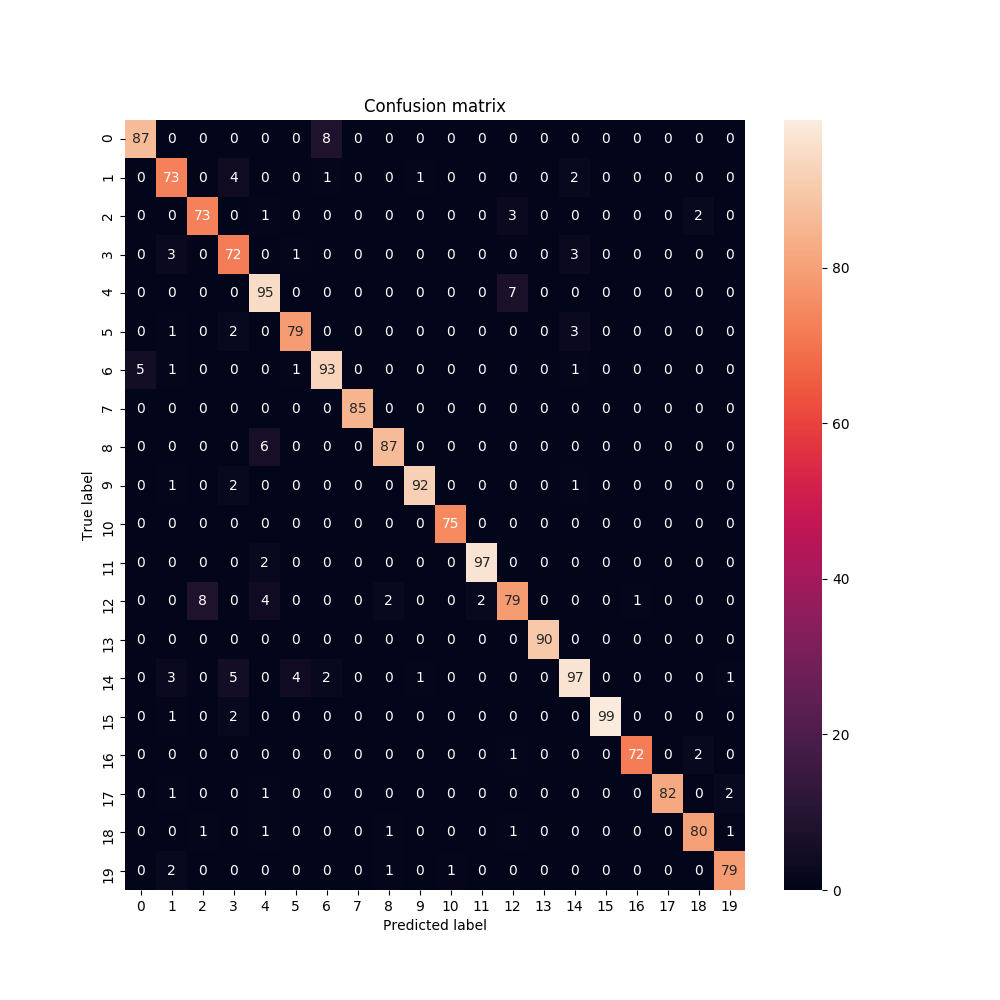

In [115]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [122]:
model = XGBClassifier(learning_rate = 0.1, n_estimators = 1000, max_depth = 5, min_child_weight = 1, gamma = 0, subsample = 0.8, colsample_bytree = 0.8, objective= 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed=27)

model.fit(scaled_x_train, y_train)

y_pred = model.predict(scaled_x_test)

predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 95.28%


In [123]:
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(scaled_x_test, y_test)
eli5.show_weights(perm, feature_names = statistical_data.columns.tolist())

Weight,Feature
0.0601 ± 0.0059,corr_Y_Z
0.0389 ± 0.0102,Z_Median
0.0143 ± 0.0070,Y_Median
0.0134 ± 0.0049,Z_magnitude_median
0.0129 ± 0.0067,X_Mean
0.0129 ± 0.0037,Z_Max
0.0119 ± 0.0058,Y_Min
0.0119 ± 0.0026,X_magnitude_median
0.0110 ± 0.0029,X_Max
0.0092 ± 0.0046,Z_Mean


<IPython.core.display.Javascript object>


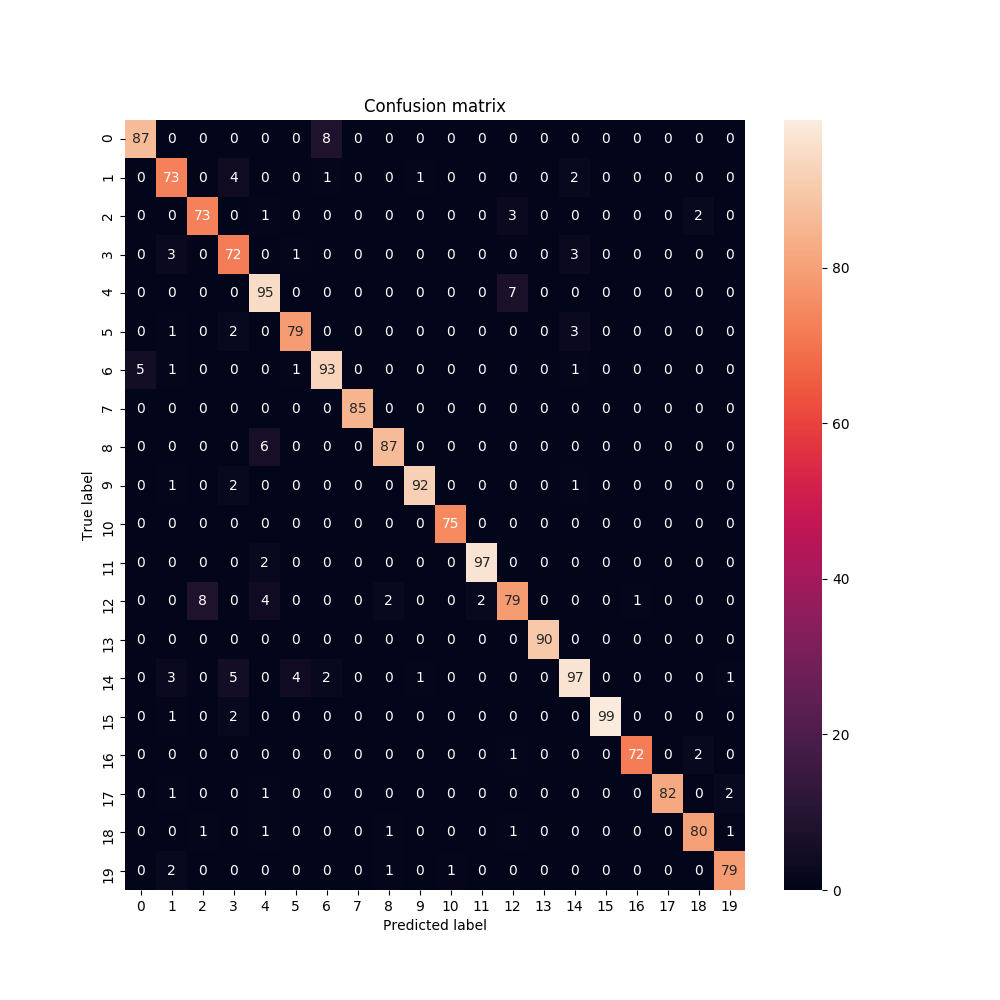

In [124]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

In [ ]:
# Redo Preprocessing Steps for Test

In [135]:
interpolated_dataframes_test = []
for i in range(len(raw_test_dataframes)):
    interpolated_dataframes_test.append(interpolate_data(raw_test_dataframes[i]))

In [136]:
statistical_test = convert_raw_to_statistics(interpolated_dataframes_test)

In [137]:
# statistical_test.drop(to_remove, inplace = True, axis = 1)
# display(statistical_test.head(n = 10))

In [138]:
scaled_x_test = scaler.transform(statistical_test)

In [139]:
predictions_SVM = classifier.predict(scaled_x_test)

y_pred = model.predict(scaled_x_test)

predictions_XGB = [round(value) for value in y_pred]

In [147]:
column_names = ["id", "class"]
submission = pd.DataFrame(columns = column_names)
submission["id"] = test_names
submission["class"] = predictions_SVM
display(submission.head(n = 5))

submission.to_csv("submission_final_SVM.csv", sep = ",", columns = ["id","class"], index=False)

,id,class
0,10001,3
1,10002,4
2,10004,5
3,10008,20
4,10009,13


In [148]:
column_names = ["id", "class"]
submission = pd.DataFrame(columns = column_names)
submission["id"] = test_names
submission["class"] = predictions_XGB
display(submission.head(n = 5))

submission.to_csv("submission_final_XGB.csv", sep = ",", columns = ["id","class"], index=False)

,id,class
0,10001,3
1,10002,4
2,10004,5
3,10008,20
4,10009,13


In [143]:
counter = 0
for i in range(len(predictions_XGB)):
    if predictions_XGB[i] != predictions_SVM[i]:
        counter += 1;

print("Numarul de elemente diferite: " + str(counter))

Numarul de elemente diferite: 684
